In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,BatchNormalization 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import pandas as pd

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#import splitfolders
import os
import cv2
import numpy as np
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

In [13]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#dataset split
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/NSU/Fake_med/Dataset1', output="splitted_data", seed=1337, ratio=(.85, 0.1,0.05)) 

Copying files: 4200 files [00:25, 165.90 files/s]


In [5]:
!zip -r '/content/splitted_data.zip' '/content/splitted_data'

!cp '/content/splitted_data.zip' -d '/content/drive/MyDrive/NSU/Fake_med'

updating: content/splitted_data/ (stored 0%)
updating: content/splitted_data/train/ (stored 0%)
updating: content/splitted_data/train/Real/ (stored 0%)
updating: content/splitted_data/train/Real/Tuberculosis-621.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-93.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-486.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-650.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-72.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-505.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-434.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-291.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-261.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-641.png (deflated 0%)
updating: content/splitted_data/train/Real/Tuberculosis-107.png (defla

In [6]:
!cp '/content/drive/MyDrive/NSU/Fake_med/splitted_data.zip' -d '/content'
!unzip '/content/splitted_data.zip'

Archive:  /content/splitted_data.zip
replace content/splitted_data/train/Real/Tuberculosis-621.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/splitted_data/train/Real/Tuberculosis-621.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-93.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-486.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-650.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-72.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-505.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-434.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-291.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-261.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-641.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-107.png  
  inflating: content/splitted_data/train/Real/Tuberculosis-521.png  
  inflating: content/splitted_data

In [7]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
labels = ['Real', 'Fake']
img_size = 128
def get_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
    

In [9]:
train = get_data('/content/splitted_data/train')
val = get_data('/content/splitted_data/val')
test = get_data('/content/splitted_data/test')

<ipython-input-8-4ee132a2c19a>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [10]:
x_train = []
y_train = []
x_val = []
y_val = []

x_test=[]
y_test=[]

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test)/255


x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
x_train.shape

(3570, 128, 128, 3)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,
        fill_mode='nearest',  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
def get_model():

  model = Sequential()
  model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(128,128,3)))
  model.add(MaxPool2D())

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(Dropout(0.2))

  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D())

  model.add(Conv2D(128, 3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(MaxPool2D())

  model.add(Conv2D(128, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(128,activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(2, activation="softmax"))

  return model

model=get_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        3

In [15]:
opt = Adam(learning_rate=0.01)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [16]:
history = model.fit(x_train,y_train,epochs = 10,batch_size=64 , validation_data = (x_val, y_val))

Epoch 1/10
56/56 [==============================] - 24s 97ms/step - loss: 1.4085 - accuracy: 0.8599 - val_loss: 1.1952 - val_accuracy: 0.8357
Epoch 2/10
56/56 [==============================] - 4s 69ms/step - loss: 0.1667 - accuracy: 0.9420 - val_loss: 0.7115 - val_accuracy: 0.8429
Epoch 3/10
56/56 [==============================] - 4s 69ms/step - loss: 0.1999 - accuracy: 0.9244 - val_loss: 0.2858 - val_accuracy: 0.9000
Epoch 4/10
56/56 [==============================] - 4s 69ms/step - loss: 0.1187 - accuracy: 0.9563 - val_loss: 0.1314 - val_accuracy: 0.9476
Epoch 5/10
56/56 [==============================] - 4s 67ms/step - loss: 0.1063 - accuracy: 0.9644 - val_loss: 0.3227 - val_accuracy: 0.9286
Epoch 6/10
56/56 [==============================] - 4s 70ms/step - loss: 0.0862 - accuracy: 0.9725 - val_loss: 0.1594 - val_accuracy: 0.9310
Epoch 7/10
56/56 [==============================] - 4s 67ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.1162 - val_accuracy: 0.9571
Epoch 8/10
5

In [17]:
scores = model.evaluate(x_test,y_test , verbose=1)

7/7 [==============================] - 1s 43ms/step - loss: 0.1174 - accuracy: 0.9762


In [18]:
accuracy= scores[1]*100
loss=scores[0]
print('Accuracy: ', accuracy)
print('Loss: ',  loss)

Accuracy:  97.6190447807312
Loss:  0.11736727505922318


In [19]:
model.save("model.h5")

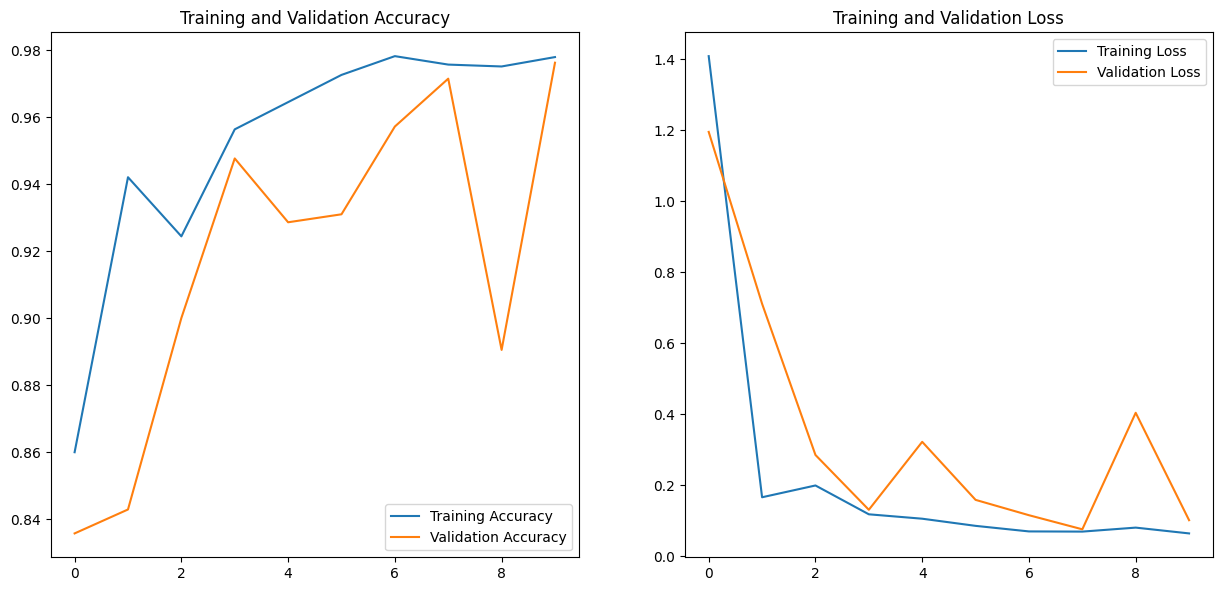

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model=tf.keras.models.load_model('model.h5')

In [48]:
test_data_dir= '/content/splitted_data/test'
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir
                                                           , target_size=(128, 128)
                                                           , batch_size=5
                                                           , classes=labels
                                                           , seed=0
                                                           , shuffle=False)

Found 210 images belonging to 2 classes.


In [49]:
train_data_dir='/content/splitted_data/train'
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir
                                                           , target_size=(128, 128)
                                                           , batch_size=10
                                                           , classes=labels
                                                           , seed=0
                                                           , shuffle=True)

Found 3570 images belonging to 2 classes.


In [50]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [51]:
predictions = probability_model.predict(test_generator)

42/42 [==============================] - 2s 39ms/step


In [52]:
predictions[39]

array([0.26894143, 0.73105854], dtype=float32)

In [53]:
np.argmax(predictions[39])

1

Plot Confusion matrix

42/42 [==============================] - 3s 73ms/step


(<Figure size 800x800 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

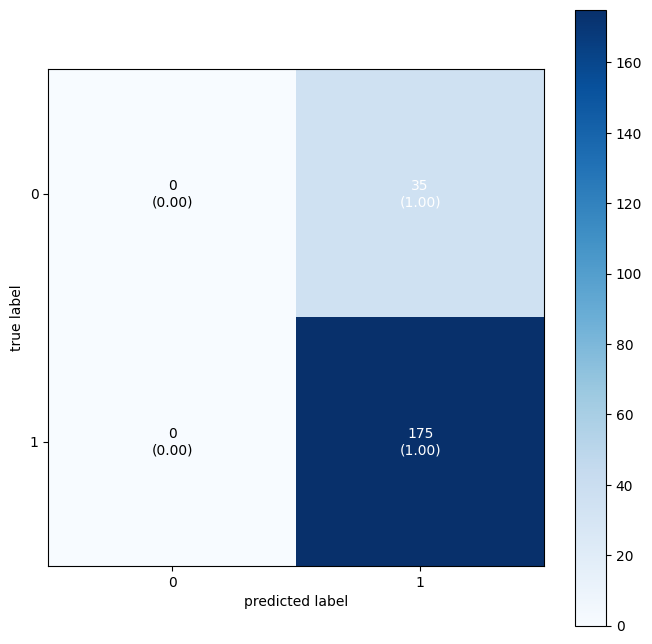

In [54]:
actual = test_generator.classes
predict = np.argmax(model.predict(test_generator),axis =1)
cm=confusion_matrix(actual,predict)
plot_confusion_matrix(cm,figsize=(8,8),
                    colorbar=True,show_normed=True,)

In [58]:
from sklearn.metrics import accuracy_score, f1_score


true_labels = actual  
predicted_labels = predict 

# Calculate the F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the F1 score and accuracy
print("F1 Score:", f1)
print("Accuracy:", accuracy)


F1 Score: 0.7575757575757576
Accuracy: 0.8333333333333334
